In [1]:
import warnings

import iris


url = 'http://crow.marine.usf.edu:8080/thredds/dodsC/FVCOM-Nowcast-Agg.nc'


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(url)

In [2]:
salt = cubes.extract_strict('sea_water_salinity')[-1, ...]  # Last time step.

lon = salt.coord(axis='X').points
lat = salt.coord(axis='Y').points

In [3]:
p = salt.coord('sea_surface_height_above_reference_ellipsoid').points
q = salt.data

In [4]:
import numpy as np

from ciso import zslice

p0 = -25

isoslice = zslice(q, p, -25)

In [5]:
import numpy.ma as ma

# For some reason I cannot tricontourf with NaNs.
isoslice = ma.masked_invalid(isoslice)
vmin, vmax = isoslice.min(), isoslice.max()
isoslice = isoslice.filled(fill_value=-999)

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

cmap = plt.cm.viridis

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines('50m')
    return fig, ax

In [7]:
import pyugrid
import matplotlib.tri as tri

ugrid = pyugrid.UGrid.from_ncfile(url)

lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

triang = tri.Triangulation(lon, lat, triangles=triangles)

In [8]:
cmap

/home/filipe/miniconda/envs/IOOS/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


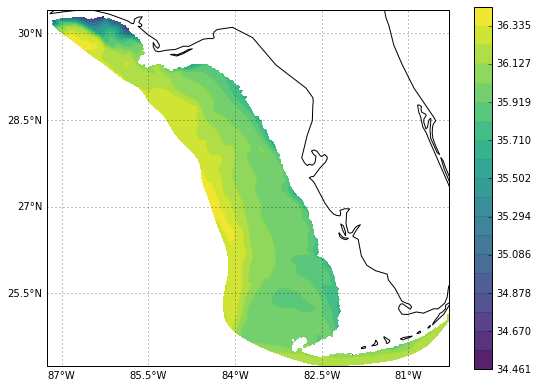

In [9]:
fig, ax = make_map()
extent = [lon.min(), lon.max(),
          lat.min(), lat.max()]
ax.set_extent(extent)

levels = np.linspace(vmin, vmax, 20)

kw = dict(cmap=cmap, alpha=0.9, levels=levels)
cs = ax.tricontourf(triang, isoslice, **kw)
kw = dict(shrink=0.5, orientation='vertical')
cbar = fig.colorbar(cs, **kw)